In [1]:
# Cell 1: Install dependencies (run once per environment)
!pip install shap lime dice-ml anchor-exp xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.0 MB/s eta 0:00:00


In [2]:
# Cell 2: Core imports

import numpy as np
import pandas as pd
import pickle
import joblib

from sklearn.model_selection import train_test_split

import xgboost as xgb

# SHAP & LIME
import shap
import lime.lime_tabular as lime_tabular

# DiCE
import dice_ml

# Anchors (from anchor-exp)
from anchor import anchor_tabular

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
# PDATED Cell 3 :

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle, joblib

RAW_DATA_PATH = "loan_default.csv"
MODEL_PATH_RESEARCH = "xgboost_loan_default_research.pkl"

# --------------------------
# 1) Load raw dataset
# --------------------------
df = pd.read_csv(RAW_DATA_PATH)

print("Raw data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop any rows with missing values (mirrors training pipeline)
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]
print(f"\nRows before dropna: {rows_before}, after dropna: {rows_after}")
print("Shape after dropna:", df.shape)

# --------------------------
# 2) Drop ID column if present
# --------------------------
if "LoanID" in df.columns:
    df = df.drop(columns=["LoanID"])

# --------------------------
# 3) Clean binary 0/1 columns robustly
# --------------------------
binary_cols = ["HasMortgage", "HasDependents", "HasCoSigner"]

for col in binary_cols:
    if col in df.columns:
        s = df[col]

        # If column is already numeric, normalize to 0/1 and continue
        if pd.api.types.is_numeric_dtype(s):
            df[col] = (
                s.fillna(0)           # missing → 0
                 .round()             # 0.0/1.0 → 0/1
                 .clip(0, 1)          # in case of weird values
                 .astype(int)
            )
            continue

        # Normalize text strings
        s_norm = (
            s.astype(str)
             .str.strip()
             .str.lower()
        )

        mapping = {
            "yes": 1, "no": 0,
            "y": 1,   "n": 0,
            "1": 1,   "0": 0,
            "true": 1, "false": 0,
        }

        mapped = s_norm.map(mapping)

        # Fix unmapped values by filling with mode
        if mapped.isna().any():
            if mapped.notna().any():
                mode_val = int(mapped.mode()[0])
                mapped = mapped.fillna(mode_val)
            else:
                raise ValueError(
                    f"Column '{col}' contains values that cannot be mapped to 0/1. "
                    f"Sample raw values: {s.unique()[:10]}"
                )

        df[col] = mapped.astype(int)

# --------------------------
# 4) One-hot encode categoricals (same as training)
# --------------------------
categorical_features = ["Education", "EmploymentType", "MaritalStatus", "LoanPurpose"]
categorical_features = [c for c in categorical_features if c in df.columns]

df_encoded = pd.get_dummies(
    df,
    columns=categorical_features,
    drop_first=True
)

# --------------------------
# 5) Separate features and target
# --------------------------
target_col = "Default"

if target_col not in df_encoded.columns:
    raise ValueError(
        f"Target column '{target_col}' not found. Columns are: {df_encoded.columns.tolist()}"
    )

X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col].astype(int)

feature_cols = X.columns.tolist()

print("Encoded X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 feature names:", feature_cols[:5])

# --------------------------
# 6) Load trained model (research artifact if available)
# --------------------------
artifact = None
model = None
trained_feature_cols = feature_cols  # fallback
DEFAULT_THRESHOLD = 0.50             # will be overwritten if found in artifact

try:
    with open(MODEL_PATH_RESEARCH, "rb") as f:
        artifact = pickle.load(f)
    print(f"Loaded research artifact from '{MODEL_PATH_RESEARCH}'.")

    if isinstance(artifact, dict) and "model" in artifact:
        model = artifact["model"]
        trained_feature_cols = artifact.get("feature_names", feature_cols)
        DEFAULT_THRESHOLD = float(artifact.get("default_threshold", 0.50))
        print("Using model + feature_names + default_threshold from artifact.")
    else:
        # artifact itself is a model
        model = artifact
        print("Artifact is a plain model object; using current feature_cols.")
except Exception as e:
    print(f"Failed to load research artifact: {e}")
    print(f"Falling back to simple model file '{MODEL_PATH_FALLBACK}'...")
    try:
        model = joblib.load(MODEL_PATH_FALLBACK)
        print("Fallback model loaded with joblib.")
    except Exception as e2:
        print("joblib.load failed, trying pickle.load; error:", e2)
        with open(MODEL_PATH_FALLBACK, "rb") as f:
            model = pickle.load(f)
        print("Fallback model loaded with pickle.")
    trained_feature_cols = feature_cols
    DEFAULT_THRESHOLD = 0.50

# --------------------------
# 7) Align X columns to model's expected feature set
# --------------------------
if set(trained_feature_cols) != set(feature_cols):
    print("\nAligning X columns to trained model feature set...")
    # Add any missing columns as zeros
    for col in trained_feature_cols:
        if col not in X.columns:
            X[col] = 0.0
    # Drop extra columns not used by the model
    extra_cols = [c for c in X.columns if c not in trained_feature_cols]
    if extra_cols:
        print("Dropping extra columns not used by the model:", extra_cols)
        X = X.drop(columns=extra_cols)
    # Reorder
    X = X[trained_feature_cols]
    feature_cols = trained_feature_cols

print("\nFinal X shape after alignment:", X.shape)
print("Number of features expected by model:", len(feature_cols))
print("DEFAULT_THRESHOLD (from artifact or fallback):", DEFAULT_THRESHOLD)

# --------------------------
# 8) Train/test split for XAI evaluation
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# Safety: ensure numeric dtypes for XGBoost + SHAP + DiCE
X_train[feature_cols] = X_train[feature_cols].astype(np.float32)
X_test[feature_cols] = X_test[feature_cols].astype(np.float32)
print("\nDtypes after cast (head):")
print(X_train.dtypes.head())


Raw data shape: (255347, 18)
Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']

Missing values per column:
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

Rows before dropna: 255347, after dropna: 255347
Shape after dropna: (255347, 18)
Encoded X shape: (255347, 24)
y shape: (255347,)
First 5 feature names: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed']


/tmp/ipython-input-1338502093.py:123: UserWarning: [12:59:57] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  artifact = pickle.load(f)


Loaded research artifact from 'xgboost_loan_default_research.pkl'.
Using model + feature_names + default_threshold from artifact.

Final X shape after alignment: (255347, 24)
Number of features expected by model: 24
DEFAULT_THRESHOLD (from artifact or fallback): 0.43000000000000005
Train shape: (204277, 24)
Test shape : (51070, 24)

Dtypes after cast (head):
Age               float32
Income            float32
LoanAmount        float32
CreditScore       float32
MonthsEmployed    float32
dtype: object


In [4]:
# Cell 4: Train/test split for XAI evaluation

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# Dataset and sample sizes summary
print("\n" + "="*80)
print("DATASET AND SAMPLE SIZES")
print("="*80)
print(f"Full Dataset: {len(df):,} observations")
print(f"Training Set: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test Set: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")
print(f"Features: {len(feature_cols)}")
print("="*80 + "\n")


Train shape: (204277, 24)
Test shape : (51070, 24)

DATASET AND SAMPLE SIZES
Full Dataset: 255,347 observations
Training Set: 204,277 (80.0%)
Test Set: 51,070 (20.0%)
Features: 24



In [5]:
# Cell 5: SHAP explainer setup

import matplotlib.pyplot as plt
import shap

shap.initjs()

# Use a subset of training data as background to speed things up
background_size = min(1000, len(X_train))
background_data = X_train.sample(background_size, random_state=RANDOM_STATE)

# Ensure background_data is explicitly float32 for SHAP
background_data = background_data.astype(np.float32)

# Use background_data explicitly for TreeExplainer
shap_explainer = shap.TreeExplainer(model, data=background_data)

# SHAP values for test set (binary: assume class 1 = default probability)
# Ensure X_test is explicitly float32 for SHAP values calculation
X_test_for_shap = X_test.astype(np.float32)
shap_values = shap_explainer.shap_values(X_test_for_shap)

print("SHAP values shape:", np.array(shap_values).shape)


100%|===================| 51048/51070 [21:58<00:00]       

SHAP values shape: (51070, 24)


In [6]:
# Cell 6: LIME explainer setup

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_cols,
    class_names=["No Default", "Default"],
    mode="classification",
    discretize_continuous=True,
    random_state=RANDOM_STATE
)

def explain_with_lime(instance_idx, num_features=10, num_samples=1000):
    """
    Returns LIME explanation as list of (feature, weight) for one test instance.
    """
    row = X_test.iloc[instance_idx].values
    exp = lime_explainer.explain_instance(
        data_row=row,
        predict_fn=model.predict_proba,
        num_features=num_features,
        num_samples=num_samples
    )
    return exp


In [7]:
# Cell 7: DiCE setup for counterfactuals (fixed dtypes + constraints)

import dice_ml
import numpy as np
import warnings

# 🔇 OPTIONAL: silence the specific FutureWarning from dice_random
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="dice_ml.explainer_interfaces.dice_random"
)

# Build training DataFrame including target for DiCE
# Use float64 to avoid dtype mismatch warnings inside DiCE
train_df_for_dice = X_train.copy()
train_df_for_dice[feature_cols] = train_df_for_dice[feature_cols].astype(np.float64)

# Make sure target is int
train_df_for_dice[target_col] = y_train.values.astype(int)

# All features are numeric after encoding, treat them as continuous
continuous_features = feature_cols
categorical_features_for_dice = []  # keep empty unless you want special handling

data_dice = dice_ml.Data(
    dataframe=train_df_for_dice,
    continuous_features=continuous_features,
    outcome_name=target_col
)

# Wrap the XGBoost sklearn model
model_dice = dice_ml.Model(
    model=model,
    backend="sklearn"
)

dice_explainer = dice_ml.Dice(
    data_interface=data_dice,
    model_interface=model_dice,
    method="random"  # or 'genetic' if you want later
)

# ========= Domain constraints for counterfactuals =========

# Features that should NOT be changed by DiCE (immutable)
IMMUTABLE_FEATURES = ["Age"]  # adjust if you consider other features immutable

# Allow all other features to vary
FEATURES_TO_VARY = [f for f in feature_cols if f not in IMMUTABLE_FEATURES]

# Global permitted ranges per feature (based on training data)
permitted_range = {}

if "Age" in feature_cols:
    permitted_range["Age"] = [
        max(18, float(X_train["Age"].min())),
        min(80, float(X_train["Age"].max()))
    ]

if "Income" in feature_cols:
    permitted_range["Income"] = [
        float(X_train["Income"].quantile(0.01)),
        float(X_train["Income"].quantile(0.99))
    ]

if "CreditScore" in feature_cols:
    permitted_range["CreditScore"] = [
        float(X_train["CreditScore"].quantile(0.01)),
        float(X_train["CreditScore"].quantile(0.99))
    ]

if "MonthsEmployed" in feature_cols:
    permitted_range["MonthsEmployed"] = [
        float(X_train["MonthsEmployed"].quantile(0.01)),
        float(X_train["MonthsEmployed"].quantile(0.99))
    ]

def generate_dice_cf(instance_idx, total_cfs=3, desired_class="opposite"):
    """
    Generate counterfactuals for one test instance.
    Returns DiCE CounterfactualExamples object.
    Ensures query instance is numeric (float64) and respects
    domain constraints (immutable features + permitted ranges).
    """
    # Take one row and ensure float64 dtypes
    query_instance = X_test.iloc[[instance_idx]].copy()
    query_instance[feature_cols] = query_instance[feature_cols].astype(np.float64)

    dice_exp = dice_explainer.generate_counterfactuals(
        query_instances=query_instance,
        total_CFs=total_cfs,
        desired_class=desired_class,
        features_to_vary=FEATURES_TO_VARY,
        verbose=False,
        permitted_range=permitted_range
    )
    return dice_exp


In [8]:
# Cell 8: Anchors explainer setup

# If you have categorical features indices, define them here.
# For now, we'll assume everything is treated as numeric and leave categorical_names empty.
categorical_names = {}  # e.g. {0: ["A", "B"], 3: ["Yes", "No"]} if needed

anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=["No Default", "Default"],
    feature_names=feature_cols,
    train_data=X_train.values,
    categorical_names=categorical_names
)

def explain_with_anchor(instance_idx, threshold=0.90):
    """
    Generate an anchor explanation (IF-THEN rule) for one test instance.
    Returns the anchor explanation object.
    """
    instance = X_test.iloc[instance_idx].values
    exp = anchor_explainer.explain_instance(
        instance,
        model.predict,     # note: classification, not predict_proba
        threshold=threshold
    )
    return exp


In [9]:
# Cell 9: Quick sanity check on one test instance

test_idx = 0  # change as needed

x_row = X_test.iloc[[test_idx]]
pred_proba = model.predict_proba(x_row)[0, 1]
pred_class = int(pred_proba >= 0.5)

print(f"Instance index in X_test: {test_idx}")
print(f"Predicted proba (Default=1): {pred_proba:.4f}")
print(f"Predicted class: {pred_class}")
print(f"Actual class: {int(y_test.iloc[test_idx])}")

# 1) SHAP (top features)
shap_vals_row = shap_values[test_idx]
shap_abs_sorted_idx = np.argsort(-np.abs(shap_vals_row))
top_k = 5
print("\n[SHAP] Top 5 features:")
for i in shap_abs_sorted_idx[:top_k]:
    print(f"  {feature_cols[i]}: {shap_vals_row[i]:.4f}")

# 2) LIME
lime_exp = explain_with_lime(test_idx, num_features=5)
print("\n[LIME] Top 5 features:")
for feat, weight in lime_exp.as_list():
    print(f"  {feat}: {weight:.4f}")

# 3) DiCE Counterfactuals
dice_exp = generate_dice_cf(test_idx, total_cfs=3)
print("\n[DiCE] Counterfactuals (showing only changes):")
try:
    dice_df = dice_exp.cf_examples_list[0].final_cfs_df
    # Show only changed values vs original
    original = x_row.iloc[0]
    for idx_cf in range(len(dice_df)):
        print(f"\n  CF #{idx_cf+1}:")
        for col in feature_cols:
            orig_val = original[col]
            cf_val = dice_df.iloc[idx_cf][col]
            if orig_val != cf_val:
                print(f"    {col}: {orig_val} → {cf_val}")
except Exception as e:
    print("  Error inspecting DiCE output:", e)

# 4) Anchors
anchor_exp = explain_with_anchor(test_idx, threshold=0.90)
print("\n[ANCHOR] Rule:")
print("  IF", " AND ".join(anchor_exp.names()), "THEN", ["No Default", "Default"][pred_class])
print(f"  Precision: {anchor_exp.precision():.3f}")
print(f"  Coverage:  {anchor_exp.coverage():.3f}")


Instance index in X_test: 0
Predicted proba (Default=1): 0.2365
Predicted class: 0
Actual class: 0

[SHAP] Top 5 features:
  Income: 0.8058
  MonthsEmployed: -0.3652
  Age: -0.3618
  InterestRate: -0.3328
  LoanAmount: -0.3034

[LIME] Top 5 features:
  Income <= 48842.00: 0.1337
  MonthsEmployed > 90.00: -0.1201
  44.00 < Age <= 56.00: -0.0804
  EmploymentType_Unemployed <= 0.00: -0.0666
  0.00 < HasDependents <= 1.00: -0.0577


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



[DiCE] Counterfactuals (showing only changes):

  CF #1:
    LoanAmount: 87156 → 208872.1

  CF #2:
    LoanAmount: 87156 → 185919.4
    HasDependents: 1 → 0.8

  CF #3:
    LoanAmount: 87156 → 218332.9
    InterestRate: 8.99 → 20.27

[ANCHOR] Rule:
  IF Age > 44.00 AND InterestRate <= 13.45 THEN No Default
  Precision: 0.948
  Coverage:  0.247


/tmp/ipython-input-1857390185.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)


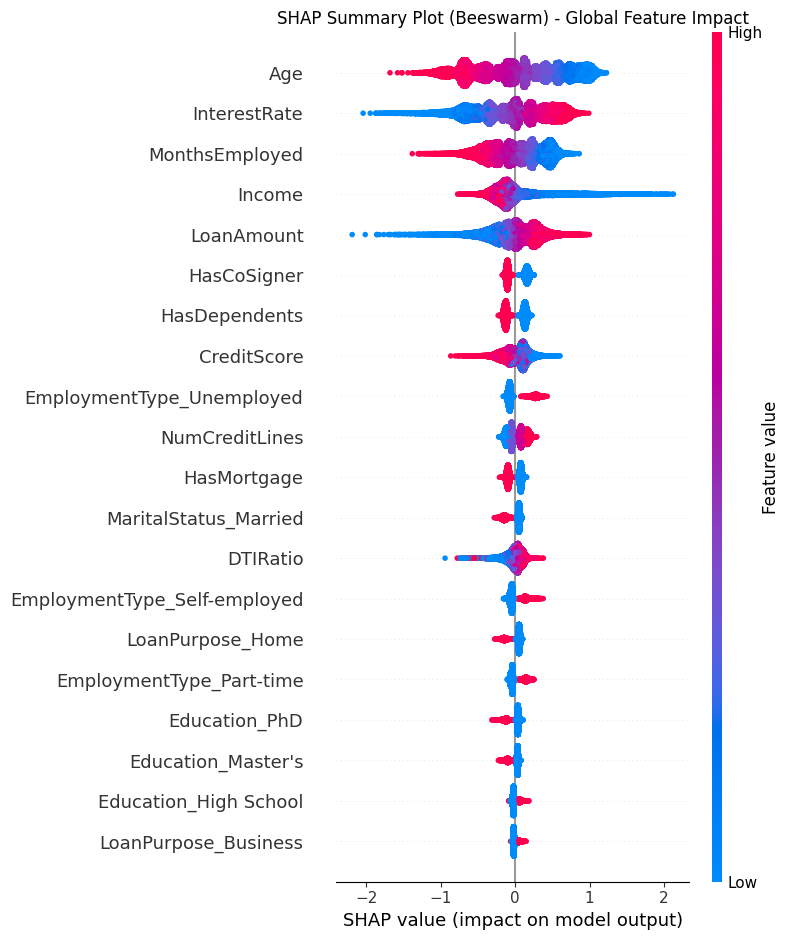

/tmp/ipython-input-1857390185.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols,


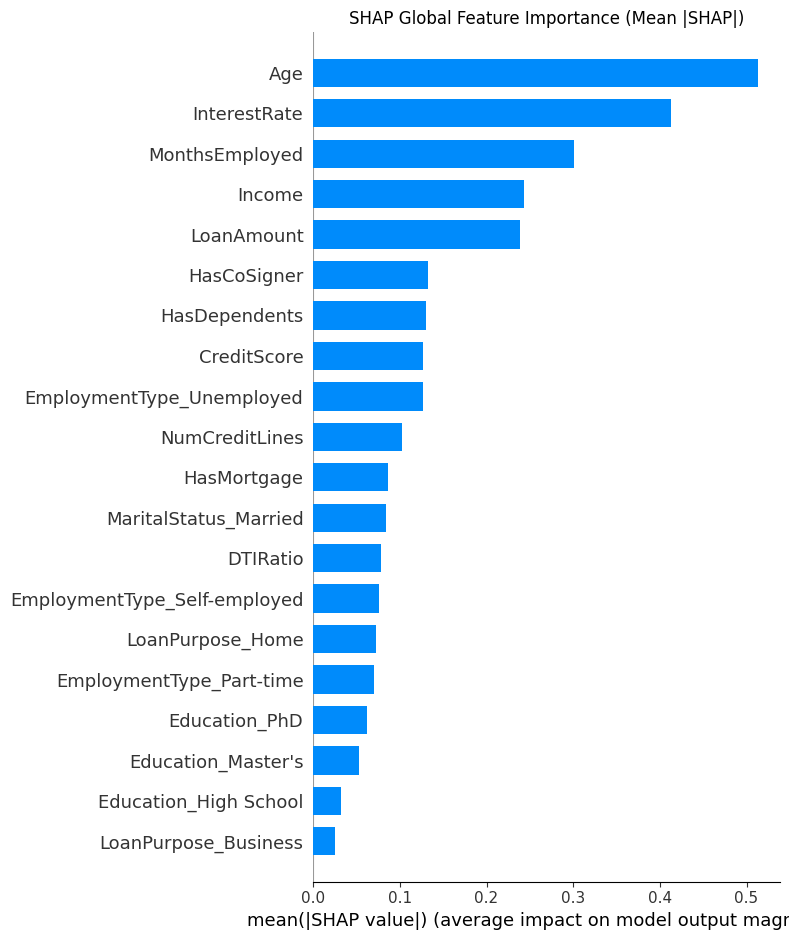

In [10]:
# Cell A: Global SHAP visualizations

import matplotlib.pyplot as plt
import shap

shap.initjs()

# 1) SHAP summary (beeswarm) – global view
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title("SHAP Summary Plot (Beeswarm) - Global Feature Impact")
plt.tight_layout()
plt.show()

# 2) SHAP bar plot – mean |SHAP| per feature
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=feature_cols,
                  plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Mean |SHAP|)")
plt.tight_layout()
plt.show()


In [11]:
# Cell B: Local SHAP force plot for a single instance (test_idx)

instance = X_test.iloc[test_idx]
instance_shap = shap_values[test_idx]

shap.initjs()

shap.force_plot(
    shap_explainer.expected_value,
    instance_shap,
    instance,
    matplotlib=False # Changed to False
)


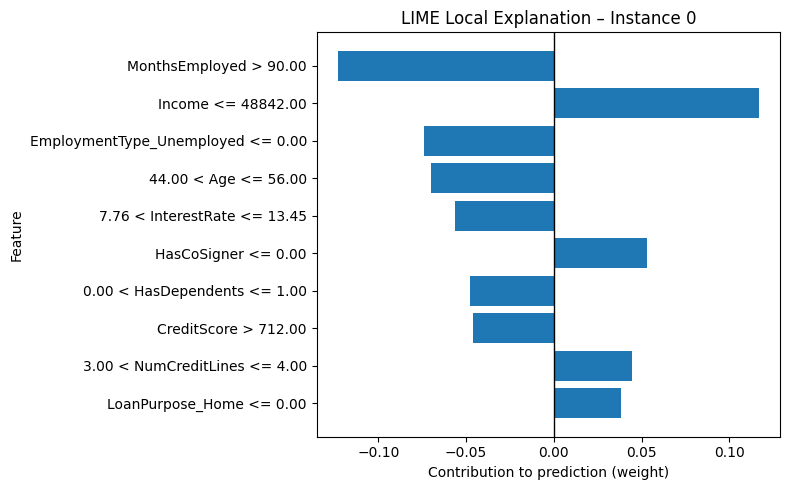

In [12]:
# Cell C: Visualize LIME explanation as a horizontal bar plot

import pandas as pd
import matplotlib.pyplot as plt

lime_exp = explain_with_lime(test_idx, num_features=10)
lime_list = lime_exp.as_list()

lime_df = pd.DataFrame(lime_list, columns=["feature", "weight"])

plt.figure(figsize=(8, 5))
plt.barh(lime_df["feature"], lime_df["weight"])
plt.axvline(0, color="black", linewidth=1)
plt.title(f"LIME Local Explanation – Instance {test_idx}")
plt.xlabel("Contribution to prediction (weight)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # top feature at top
plt.tight_layout()
plt.show()


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

=== DiCE Counterfactuals (raw values) ===


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,HasMortgage,...,Education_PhD,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,54.0,20956.0,224761.0,789.0,102.0,4.0,8.99,24.0,0.65,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,54.0,20956.0,227087.5,789.0,102.0,4.0,8.99,24.0,0.65,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,54.0,20956.0,87156.0,789.0,102.0,4.0,23.89,24.0,0.65,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0



=== Changes relative to original (CF - original) ===


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,HasMortgage,...,Education_PhD,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,0.0,0.0,137605.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,139931.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,14.9,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


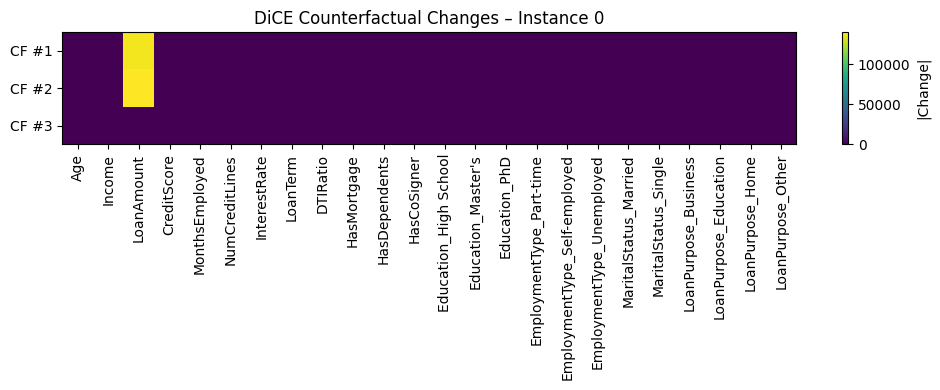

In [13]:
# Cell D: Visualize DiCE counterfactuals for one instance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate counterfactuals
dice_exp = generate_dice_cf(test_idx, total_cfs=3)
cf_df = dice_exp.cf_examples_list[0].final_cfs_df[feature_cols].copy()

print("=== DiCE Counterfactuals (raw values) ===")
display(cf_df)

# Build a diff matrix (CF - original) for visualization
original = X_test.iloc[[test_idx]][feature_cols].iloc[0]
diff_df = cf_df.copy()
for col in feature_cols:
    diff_df[col] = cf_df[col] - original[col]

print("\n=== Changes relative to original (CF - original) ===")
display(diff_df)

# Simple heatmap-like visualization of absolute changes
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(diff_df.values), aspect="auto")
plt.colorbar(label="|Change|")
plt.yticks(range(len(diff_df)), [f"CF #{i+1}" for i in range(len(diff_df))])
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.title(f"DiCE Counterfactual Changes – Instance {test_idx}")
plt.tight_layout()
plt.show()


In [14]:
# Cell E: Anchor explanation summary for one instance

anchor_exp = explain_with_anchor(test_idx, threshold=0.90)

print(f"=== Anchor Explanation – Instance {test_idx} ===")
print("Rule:")
print("  IF", " AND ".join(anchor_exp.names()), "THEN",
      ["No Default", "Default"][int(model.predict_proba(X_test.iloc[[test_idx]])[0, 1] >= 0.5)])

print(f"\nPrecision: {anchor_exp.precision():.3f}")
print(f"Coverage:  {anchor_exp.coverage():.3f}")

print("\nFeature-wise conditions:")
for name in anchor_exp.names():
    print("  -", name)


=== Anchor Explanation – Instance 0 ===
Rule:
  IF Age > 44.00 AND InterestRate <= 13.45 THEN No Default

Precision: 0.952
Coverage:  0.240

Feature-wise conditions:
  - Age > 44.00
  - InterestRate <= 13.45


In [15]:
# Cell 10: Fidelity evaluation subset + common helpers

import numpy as np
import pandas as pd
from tqdm import tqdm

# We'll work on a subset of test instances for efficiency
RNG = np.random.RandomState(42)
n_fid = min(300, len(X_test))   # you can change to 100, 200, etc.
subset_idx = RNG.choice(len(X_test), size=n_fid, replace=False)

print(f"\n📊 FIDELITY EVALUATION SAMPLE: {n_fid} instances")

# Baseline vector for masking features (use train means)
baseline_vec = X_train.mean(axis=0).values.astype(np.float32)

# Convenience: function to get model proba for class 1
def model_proba_class1(x_row_1d):
    """
    x_row_1d: 1D numpy array of shape (n_features,)
    returns P(y=1 | x)
    """
    x_row_2d = x_row_1d.reshape(1, -1).astype(np.float32)
    return float(model.predict_proba(x_row_2d)[0, 1])



📊 FIDELITY EVALUATION SAMPLE: 300 instances


In [16]:
# Cell 11: Generic insertion/deletion curves with per-instance AUCs

def insertion_deletion_from_importances(
    importances, subset_idx, X, model, baseline_vec, return_per_instance=False
):
    """
    importances: np.array shape (n_subset, n_features)
    subset_idx: indices in X_test corresponding to each row in `importances`
    X: full DataFrame (X_test)
    model: trained classifier with predict_proba
    baseline_vec: 1D baseline feature vector (e.g., train mean)
    return_per_instance: if True, also return per-instance AUCs
    """
    n_subset, n_features = importances.shape

    deletion_scores = np.zeros((n_subset, n_features + 1))
    insertion_scores = np.zeros((n_subset, n_features + 1))

    deletion_aucs = np.zeros(n_subset)
    insertion_aucs = np.zeros(n_subset)

    for j in tqdm(range(n_subset), desc="Computing insertion/deletion"):
        global_i = subset_idx[j]
        x = X.iloc[global_i].values.astype(np.float32)

        # Feature ranking (high -> low importance)
        order = np.argsort(-np.abs(importances[j]))

        # Deletion: start from full x, progressively mask features
        x_del = x.copy()
        deletion_scores[j, 0] = model_proba_class1(x_del)
        for k, f_idx in enumerate(order):
            x_del[f_idx] = baseline_vec[f_idx]
            deletion_scores[j, k+1] = model_proba_class1(x_del)

        # Insertion: start from baseline, progressively insert features
        x_ins = baseline_vec.copy()
        insertion_scores[j, 0] = model_proba_class1(x_ins)
        for k, f_idx in enumerate(order):
            x_ins[f_idx] = x[f_idx]
            insertion_scores[j, k+1] = model_proba_class1(x_ins)

        # Per-instance AUCs
        x_axis = np.linspace(0, 1, n_features + 1)
        deletion_aucs[j] = np.trapz(deletion_scores[j], x_axis)
        insertion_aucs[j] = np.trapz(insertion_scores[j], x_axis)

    # Mean curves
    mean_del = deletion_scores.mean(axis=0)
    mean_ins = insertion_scores.mean(axis=0)
    x_axis = np.linspace(0, 1, n_features + 1)

    # AUC of mean curves
    deletion_auc = np.trapz(mean_del, x_axis)
    insertion_auc = np.trapz(mean_ins, x_axis)

    result = {
        "x_axis": x_axis,
        "mean_deletion": mean_del,
        "mean_insertion": mean_ins,
        "deletion_auc": deletion_auc,
        "insertion_auc": insertion_auc,
    }

    if return_per_instance:
        result["deletion_auc_per_instance"] = deletion_aucs
        result["insertion_auc_per_instance"] = insertion_aucs

    return result


In [17]:
# Cell 12: SHAP-based insertion/deletion fidelity

# shap_values is assumed to be shape (len(X_test), n_features) for class 1
shap_subset = np.array(shap_values)[subset_idx, :]   # shape (n_fid, n_features)

shap_id_results = insertion_deletion_from_importances(
    importances=shap_subset,
    subset_idx=subset_idx,
    X=X_test,
    model=model,
    baseline_vec=baseline_vec,
    return_per_instance=True,
)

print("\n=== SHAP Insertion/Deletion AUC ===")
print(f"Deletion AUC  (SHAP): {shap_id_results['deletion_auc']:.4f}")
print(f"Insertion AUC (SHAP): {shap_id_results['insertion_auc']:.4f}")


Computing insertion/deletion:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipython-input-414953925.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  deletion_aucs[j] = np.trapz(deletion_scores[j], x_axis)
/tmp/ipython-input-414953925.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  insertion_aucs[j] = np.trapz(insertion_scores[j], x_axis)
Computing insertion/deletion: 100%|██████████| 300/300 [00:10<00:00, 28.87it/s]


=== SHAP Insertion/Deletion AUC ===
Deletion AUC  (SHAP): 0.4082
Insertion AUC (SHAP): 0.4206



/tmp/ipython-input-414953925.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  deletion_auc = np.trapz(mean_del, x_axis)
/tmp/ipython-input-414953925.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  insertion_auc = np.trapz(mean_ins, x_axis)


In [18]:
# Cell 13: LIME-based insertion/deletion fidelity

n_features = X_test.shape[1]

def get_lime_importance_vector(global_idx, num_features=None):
    """
    Returns a length-d vector of LIME weights (for class 1).
    Any feature not in top-k gets weight 0.
    """
    if num_features is None:
        num_features = n_features
    exp = explain_with_lime(global_idx, num_features=num_features)
    weights = np.zeros(n_features, dtype=float)
    # as_map()[1] -> class 1 importance (assuming binary classification)
    for feat_idx, w in exp.as_map()[1]:
        weights[feat_idx] = w
    return weights

lime_importances = np.zeros((len(subset_idx), n_features))

print("Computing LIME importance vectors for subset...")
for j, g_idx in enumerate(tqdm(subset_idx)):
    lime_importances[j] = get_lime_importance_vector(g_idx, num_features=n_features)

lime_id_results = insertion_deletion_from_importances(
    importances=lime_importances,
    subset_idx=subset_idx,
    X=X_test,
    model=model,
    baseline_vec=baseline_vec,
    return_per_instance=True,
)

print("\n=== LIME Insertion/Deletion AUC ===")
print(f"Deletion AUC  (LIME): {lime_id_results['deletion_auc']:.4f}")
print(f"Insertion AUC (LIME): {lime_id_results['insertion_auc']:.4f}")


Computing LIME importance vectors for subset...


Computing insertion/deletion:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipython-input-414953925.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  deletion_aucs[j] = np.trapz(deletion_scores[j], x_axis)
/tmp/ipython-input-414953925.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  insertion_aucs[j] = np.trapz(insertion_scores[j], x_axis)
Computing insertion/deletion: 100%|██████████| 300/300 [00:10<00:00, 28.63it/s]


=== LIME Insertion/Deletion AUC ===
Deletion AUC  (LIME): 0.4221
Insertion AUC (LIME): 0.4109



/tmp/ipython-input-414953925.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  deletion_auc = np.trapz(mean_del, x_axis)
/tmp/ipython-input-414953925.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  insertion_auc = np.trapz(mean_ins, x_axis)


In [19]:
# NEW CELL: LIME stability analysis

def measure_lime_stability(global_idx, n_runs=10, top_k=5, num_samples=5000):
    """
    For a single instance:
      - repeatedly fit LIME (same settings, different internal randomness)
      - measure:
          * mean Jaccard similarity of top-k feature sets
          * mean std of weights across runs
    """
    feature_sets = []
    weight_vectors = []

    for r in range(n_runs):
        exp = explain_with_lime(global_idx, num_features=top_k, num_samples=num_samples)
        as_map = exp.as_map()[1]  # class 1 importances

        feats = [fid for fid, w in as_map]
        weights = np.zeros(len(feature_cols))
        for fid, w in as_map:
            weights[fid] = w

        feature_sets.append(set(feats))
        weight_vectors.append(weights)

    # Pairwise Jaccard similarity of feature sets
    jaccards = []
    if len(feature_sets) > 1:
        for i in range(len(feature_sets)):
            for j in range(i+1, len(feature_sets)):
                inter = len(feature_sets[i] & feature_sets[j])
                union = len(feature_sets[i] | feature_sets[j])
                if union > 0:
                    jaccards.append(inter / union)
    mean_jaccard = float(np.mean(jaccards)) if jaccards else np.nan

    # Weight variability: average std over all features
    W = np.stack(weight_vectors, axis=0)  # shape (n_runs, n_features)
    weight_std = float(np.mean(np.std(W, axis=0)))

    return {
        "instance_idx": int(global_idx),
        "mean_jaccard": mean_jaccard,
        "weight_std": weight_std,
    }

# Run on a subset of instances
n_stab = min(30, len(X_test))
rng = np.random.RandomState(123)
stab_indices = rng.choice(len(X_test), size=n_stab, replace=False)

stability_records = []
for g_idx in tqdm(stab_indices, desc="LIME stability"):
    stability_records.append(
        measure_lime_stability(g_idx, n_runs=10, top_k=5, num_samples=5000)
    )

lime_stability_df = pd.DataFrame(stability_records)

print("\n=== LIME Stability Summary (across instances) ===")
print(lime_stability_df[["mean_jaccard", "weight_std"]].describe().round(3))


LIME stability: 100%|██████████| 30/30 [01:43<00:00,  3.46s/it]


=== LIME Stability Summary (across instances) ===
       mean_jaccard  weight_std
count        30.000      30.000
mean          0.759       0.005
std           0.060       0.001
min           0.638       0.003
25%           0.720       0.004
50%           0.763       0.004
75%           0.796       0.005
max           0.881       0.006


In [20]:
# NEW CELL: Statistical comparison of SHAP vs LIME (paired t-tests)

from scipy import stats

# AUCs per instance (same subset_idx for both)
shap_del = shap_id_results["deletion_auc_per_instance"]
lime_del = lime_id_results["deletion_auc_per_instance"]

shap_ins = shap_id_results["insertion_auc_per_instance"]
lime_ins = lime_id_results["insertion_auc_per_instance"]

def paired_t_test_and_cohen_d(a, b, label):
    """
    a, b: np arrays of same length (may include NaN)
    label: name of the metric
    """
    # remove NaNs in a paired way
    mask = ~np.isnan(a) & ~np.isnan(b)
    a_valid = a[mask]
    b_valid = b[mask]

    diff = a_valid - b_valid
    t_stat, p_val = stats.ttest_rel(a_valid, b_valid)
    if np.std(diff, ddof=1) > 0:
        cohen_d = np.mean(diff) / np.std(diff, ddof=1)
    else:
        cohen_d = np.nan

    return {
        "metric": label,
        "n": int(len(a_valid)),
        "t_stat": float(t_stat),
        "p_value": float(p_val),
        "cohen_d": float(cohen_d),
    }

ttest_results = []
ttest_results.append(
    paired_t_test_and_cohen_d(shap_del, lime_del, "deletion_auc")
)
ttest_results.append(
    paired_t_test_and_cohen_d(shap_ins, lime_ins, "insertion_auc")
)

ttest_df = pd.DataFrame(ttest_results)

print("\n=== Paired t-tests: SHAP vs LIME ===")
print(ttest_df.round(4))



=== Paired t-tests: SHAP vs LIME ===
          metric    n  t_stat  p_value  cohen_d
0   deletion_auc  300 -7.8952      0.0  -0.4558
1  insertion_auc  300  5.4462      0.0   0.3144


In [21]:
# Cell 14: ROAR (RemOve And Retrain) for SHAP & LIME

from sklearn.metrics import roc_auc_score
import xgboost as xgb

def roar_auc_drop(top_features, X_train, y_train, X_test, y_test):
    """
    Remove `top_features` columns from train & test, retrain XGBoost,
    return AUC and drop from baseline.
    """
    # Baseline AUC (full model) – compute once
    global baseline_auc_cache
    if baseline_auc_cache is None:
        y_proba_full = model.predict_proba(X_test.values)[:, 1]
        baseline_auc_cache = roc_auc_score(y_test, y_proba_full)

    X_train_red = X_train.drop(columns=top_features)
    X_test_red  = X_test.drop(columns=top_features)

    temp_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=-1,
    )
    temp_model.fit(X_train_red, y_train)

    y_proba_red = temp_model.predict_proba(X_test_red.values)[:, 1]
    auc_red = roc_auc_score(y_test, y_proba_red)
    return auc_red, baseline_auc_cache - auc_red

baseline_auc_cache = None  # will be filled first time we call roar_auc_drop

# Global feature importance from SHAP mean |value|
shap_global_importance = np.mean(np.abs(shap_values), axis=0)
shap_global_importance = pd.Series(
    shap_global_importance, index=feature_cols
).sort_values(ascending=False)

# Global feature importance from LIME mean |value|
lime_global_importance = np.mean(np.abs(lime_importances), axis=0)
lime_global_importance = pd.Series(
    lime_global_importance, index=feature_cols
).sort_values(ascending=False)

# Print baseline AUC explicitly (compute if needed)
if baseline_auc_cache is None:
    y_proba_full = model.predict_proba(X_test.values)[:, 1]
    baseline_auc_cache = roc_auc_score(y_test, y_proba_full)

print("Baseline AUC (full model):", baseline_auc_cache)

ks = [3, 5, 10]
roar_records = []

for k in ks:
    shap_topk = list(shap_global_importance.index[:k])
    lime_topk = list(lime_global_importance.index[:k])

    shap_auc_after, shap_drop = roar_auc_drop(shap_topk, X_train, y_train, X_test, y_test)
    lime_auc_after, lime_drop = roar_auc_drop(lime_topk, X_train, y_train, X_test, y_test)

    roar_records.append({
        "method": "SHAP",
        "k_removed": k,
        "auc_after": shap_auc_after,
        "auc_drop": shap_drop
    })
    roar_records.append({
        "method": "LIME",
        "k_removed": k,
        "auc_after": lime_auc_after,
        "auc_drop": lime_drop
    })

roar_df = pd.DataFrame(roar_records)
print("\n=== ROAR Results (AUC drop after removing top-k features) ===")
print(roar_df.round(4).to_string(index=False))


Baseline AUC (full model): 0.754892873680294

=== ROAR Results (AUC drop after removing top-k features) ===
method  k_removed  auc_after  auc_drop
  SHAP          3     0.6477    0.1072
  LIME          3     0.6477    0.1072
  SHAP          5     0.5835    0.1714
  LIME          5     0.6054    0.1494
  SHAP         10     0.5468    0.2081
  LIME         10     0.5490    0.2059


In [22]:
# Cell 15: Anchors – average precision and coverage

anchor_precisions = []
anchor_coverages = []
anchor_lengths = []

n_anchor = min(200, len(subset_idx))  # you can adjust
print(f"📊 ANCHOR EVALUATION SAMPLE: {n_anchor} instances")


for g_idx in tqdm(subset_idx[:n_anchor], desc="Evaluating anchors"):
    try:
        anchor_exp = explain_with_anchor(g_idx, threshold=0.90)
        p = anchor_exp.precision()
        c = anchor_exp.coverage()
        anchor_precisions.append(p)
        anchor_coverages.append(c)
        anchor_lengths.append(len(anchor_exp.names()))
    except Exception as e:
        print(f"Anchor failed for instance {g_idx}: {e}")

anchor_results = {
    "mean_precision": np.mean(anchor_precisions) if anchor_precisions else np.nan,
    "mean_coverage": np.mean(anchor_coverages) if anchor_coverages else np.nan,
    "mean_rule_length": np.mean(anchor_lengths) if anchor_lengths else np.nan,
    "n_rules": len(anchor_precisions)
}

print("\n=== Anchor Fidelity Summary ===")
for k, v in anchor_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


📊 ANCHOR EVALUATION SAMPLE: 200 instances


Evaluating anchors: 100%|██████████| 200/200 [12:08<00:00,  3.64s/it]


=== Anchor Fidelity Summary ===
mean_precision: 0.9347
mean_coverage: 0.1323
mean_rule_length: 2.3150
n_rules: 200


In [23]:
# NEW CELL: Anchor sensitivity analysis over precision / coverage thresholds

thresholds = [0.85, 0.90, 0.95]
n_sens = min(200, len(subset_idx))
sens_indices = subset_idx[:n_sens]

records = []

for thr in thresholds:
    precisions = []
    coverages = []
    lengths = []

    for g_idx in sens_indices:
        try:
            exp = explain_with_anchor(g_idx, threshold=thr)
            precisions.append(exp.precision())
            coverages.append(exp.coverage())
            lengths.append(len(exp.names()))
        except Exception:
            # some instances may fail; we skip them
            continue

    records.append({
        "threshold": thr,
        "n_rules": len(precisions),
        "mean_precision": np.mean(precisions) if precisions else np.nan,
        "mean_coverage": np.mean(coverages) if coverages else np.nan,
        "mean_rule_length": np.mean(lengths) if lengths else np.nan,
    })

anchor_sensitivity_df = pd.DataFrame(records)

print("\n=== Anchor Sensitivity (precision/coverage vs threshold) ===")
print(anchor_sensitivity_df.round(3))



=== Anchor Sensitivity (precision/coverage vs threshold) ===
   threshold  n_rules  mean_precision  mean_coverage  mean_rule_length
0       0.85      200           0.898          0.222             1.800
1       0.90      200           0.934          0.137             2.285
2       0.95      200           0.972          0.077             3.070


In [24]:
# Cell 16: DiCE – counterfactual validity, proximity, sparsity, plausibility (improved)

import numpy as np
import pandas as pd

# Precompute simple plausibility ranges from training data
feature_ranges = {}
for col in feature_cols:
    col_data = X_train[col].astype(float)
    lower = float(col_data.quantile(0.01))
    upper = float(col_data.quantile(0.99))
    feature_ranges[col] = (lower, upper)

def check_counterfactual_plausibility(x_cf):
    """
    x_cf: pandas Series of CF feature values
    Returns 1 if plausibility conditions are satisfied, else 0.
    """
    # Age rule (if present)
    if "Age" in x_cf.index:
        age_cf = float(x_cf["Age"])
        if not (18 <= age_cf <= 80):
            return 0

    # Per-feature range rule
    for col in feature_cols:
        val = float(x_cf[col])
        lo, hi = feature_ranges[col]
        if val < lo - 1e-6 or val > hi + 1e-6:
            return 0

    return 1

# Identify one-hot groups based on prefixes (from original categoricals)
ONE_HOT_PREFIXES = ["Education_", "EmploymentType_", "MaritalStatus_", "LoanPurpose_"]
one_hot_groups = {
    prefix: [c for c in feature_cols if c.startswith(prefix)]
    for prefix in ONE_HOT_PREFIXES
}

# Binary features that should remain 0/1
BINARY_FEATURES = [c for c in ["HasMortgage", "HasDependents", "HasCoSigner"] if c in feature_cols]

def enforce_categorical_structure(x_cf):
    """
    Enforce:
      - One-hot structure for encoded categoricals (max 1 active per group)
      - 0/1 values for binary features
    Returns a new Series.
    """
    x_cf = x_cf.copy()

    # One-hot groups
    for prefix, cols in one_hot_groups.items():
        if not cols:
            continue
        vals = x_cf[cols].values.astype(float)
        # If all small → treat as baseline (all zeros)
        if np.all(np.abs(vals) < 0.5):
            x_cf[cols] = 0.0
        else:
            # Activate the largest value, zero out the rest
            max_idx = int(np.argmax(vals))
            for j, col in enumerate(cols):
                x_cf[col] = 1.0 if j == max_idx else 0.0

    # Binary 0/1 features
    for col in BINARY_FEATURES:
        if col in x_cf.index:
            x_cf[col] = float(x_cf[col] > 0.5)

    return x_cf

def evaluate_dice_on_subset(cf_subset_idx, total_cfs=3):
    """
    Evaluate DiCE CF quality on a subset of instance indices.
    Returns a DataFrame with:
      - validity (CF flips prediction)
      - l1 distance
      - l2 distance
      - sparsity (# features changed)
      - plausibility (0/1)
    """
    records = []

    for idx in tqdm(cf_subset_idx, desc="Evaluating DiCE CFs"):
        x_orig = X_test.iloc[idx][feature_cols].astype(float)
        proba_orig = model.predict_proba(x_orig.values.reshape(1, -1))[0, 1]
        pred_orig = int(proba_orig >= DEFAULT_THRESHOLD)

        try:
            dice_exp = generate_dice_cf(idx, total_cfs=total_cfs, desired_class="opposite")
            cf_df_raw = dice_exp.cf_examples_list[0].final_cfs_df[feature_cols].astype(float)

            for j in range(len(cf_df_raw)):
                # Enforce one-hot + binary constraints before evaluation
                x_cf = enforce_categorical_structure(cf_df_raw.iloc[j])

                proba_cf = model.predict_proba(x_cf.values.reshape(1, -1))[0, 1]
                pred_cf = int(proba_cf >= DEFAULT_THRESHOLD)

                diff = x_cf.values - x_orig.values
                l1 = np.sum(np.abs(diff))
                l2 = float(np.sqrt(np.sum(diff**2)))
                sparsity = int(np.sum(np.abs(diff) > 1e-6))

                plausibility_flag = check_counterfactual_plausibility(x_cf)

                records.append({
                    "instance_idx": int(idx),
                    "cf_index": int(j),
                    "proba_orig": float(proba_orig),
                    "proba_cf": float(proba_cf),
                    "pred_orig": int(pred_orig),
                    "pred_cf": int(pred_cf),
                    "validity": int(pred_cf != pred_orig),
                    "l1_distance": float(l1),
                    "l2_distance": l2,
                    "sparsity": sparsity,
                    "plausibility": int(plausibility_flag),
                })

        except Exception as e:
            # if DiCE generation fails for this instance, skip
            records.append({
                "instance_idx": int(idx),
                "cf_index": -1,
                "proba_orig": float(proba_orig),
                "proba_cf": np.nan,
                "pred_orig": int(pred_orig),
                "pred_cf": np.nan,
                "validity": 0,
                "l1_distance": np.nan,
                "l2_distance": np.nan,
                "sparsity": np.nan,
                "plausibility": 0,
            })
            continue

    return pd.DataFrame(records)

# === Run DiCE evaluation on subset ===
cf_subset_size = min(50, len(subset_idx))
cf_subset_idx = subset_idx[:cf_subset_size]

print(f"📊 DICE EVALUATION SAMPLE: {cf_subset_size} instances (computational limit)")

cf_metrics_df = evaluate_dice_on_subset(cf_subset_idx, total_cfs=3)

print("\nFirst few CF rows:")
print(cf_metrics_df.head().to_string(index=False))

cf_summary = {
    "n_cfs": len(cf_metrics_df),
    "validity_rate": cf_metrics_df["validity"].mean() if len(cf_metrics_df) else np.nan,
    "mean_l1_distance": cf_metrics_df["l1_distance"].mean() if len(cf_metrics_df) else np.nan,
    "mean_l2_distance": cf_metrics_df["l2_distance"].mean() if len(cf_metrics_df) else np.nan,
    "mean_sparsity": cf_metrics_df["sparsity"].mean() if len(cf_metrics_df) else np.nan,
    "plausibility_rate": cf_metrics_df["plausibility"].mean() if len(cf_metrics_df) else np.nan,
}

print("\n=== DiCE Counterfactual Metrics Summary (with plausibility) ===")
for k, v in cf_summary.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


📊 DICE EVALUATION SAMPLE: 50 instances (computational limit)


Evaluating DiCE CFs: 100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


First few CF rows:
 instance_idx  cf_index  proba_orig  proba_cf  pred_orig  pred_cf  validity  l1_distance   l2_distance  sparsity  plausibility
        33459         0    0.541578  0.541578          1        1         0         0.00      0.000000         0             1
        33459         1    0.541578  0.463527          1        1         0         1.40      1.077033         2             1
        33459         2    0.541578  0.445858          1        1         0         1.49      1.113598         2             1
        36112         0    0.281876  0.612760          0        1         1    135858.40 135858.400000         1             1
        36112         1    0.281876  0.468186          0        1         1     61468.30  61468.300000         1             1

=== DiCE Counterfactual Metrics Summary (with plausibility) ===
n_cfs: 150
validity_rate: 0.7867
mean_l1_distance: 47996.9824
mean_l2_distance: 45064.2477
mean_sparsity: 1.8267
plausibility_rate: 0.9467


In [25]:
import pandas as pd
import numpy as np

# Create a list to hold all consolidated metric rows
consolidated_metrics = []

# --- SHAP metrics ---
shap_row = {
    "method": "SHAP",
    "deletion_auc": shap_id_results['deletion_auc'],
    "insertion_auc": shap_id_results['insertion_auc'],
    "roar_auc_drop_k3": float(roar_df[(roar_df.method=="SHAP") & (roar_df.k_removed==3)]["auc_drop"]),
    "anchor_mean_precision": np.nan,
    "anchor_mean_coverage": np.nan,
    "anchor_mean_rule_length": np.nan,
    "cf_validity_rate": np.nan,
    "cf_mean_l1_distance": np.nan,
    "cf_mean_l2_distance": np.nan,
    "cf_mean_sparsity": np.nan,
    "cf_plausibility_rate": np.nan,
}
consolidated_metrics.append(shap_row)

# --- LIME metrics ---
lime_row = {
    "method": "LIME",
    "deletion_auc": lime_id_results['deletion_auc'],
    "insertion_auc": lime_id_results['insertion_auc'],
    "roar_auc_drop_k3": float(roar_df[(roar_df.method=="LIME") & (roar_df.k_removed==3)]["auc_drop"]),
    "anchor_mean_precision": np.nan,
    "anchor_mean_coverage": np.nan,
    "anchor_mean_rule_length": np.nan,
    "cf_validity_rate": np.nan,
    "cf_mean_l1_distance": np.nan,
    "cf_mean_l2_distance": np.nan,
    "cf_mean_sparsity": np.nan,
    "cf_plausibility_rate": np.nan,
}
consolidated_metrics.append(lime_row)

# --- ANCHOR metrics ---
anchor_row = {
    "method": "ANCHOR",
    "deletion_auc": np.nan, # Not directly applicable
    "insertion_auc": np.nan, # Not directly applicable
    "roar_auc_drop_k3": np.nan, # Not directly applicable
    "anchor_mean_precision": anchor_results['mean_precision'],
    "anchor_mean_coverage": anchor_results['mean_coverage'],
    "anchor_mean_rule_length": anchor_results['mean_rule_length'],
    "cf_validity_rate": np.nan,
    "cf_mean_l1_distance": np.nan,
    "cf_mean_l2_distance": np.nan,
    "cf_mean_sparsity": np.nan,
    "cf_plausibility_rate": np.nan,
}
consolidated_metrics.append(anchor_row)

# --- COUNTERFACTUAL metrics (DiCE) ---
cf_row = {
    "method": "COUNTERFACTUAL",
    "deletion_auc": np.nan, # Not directly applicable
    "insertion_auc": np.nan, # Not directly applicable
    "roar_auc_drop_k3": np.nan, # Not directly applicable
    "anchor_mean_precision": np.nan,
    "anchor_mean_coverage": np.nan,
    "anchor_mean_rule_length": np.nan,
    "cf_validity_rate": cf_summary['validity_rate'],
    "cf_mean_l1_distance": cf_summary['mean_l1_distance'],
    "cf_mean_l2_distance": cf_summary['mean_l2_distance'],
    "cf_mean_sparsity": cf_summary['mean_sparsity'],
    "cf_plausibility_rate": cf_summary['plausibility_rate'],
}
consolidated_metrics.append(cf_row)

# Create DataFrame and save to CSV
comprehensive_tech_df = pd.DataFrame(consolidated_metrics)
comprehensive_tech_df.to_csv("comprehensive_technical_xai_evaluations.csv", index=False)

print("Comprehensive technical XAI evaluations saved to 'comprehensive_technical_xai_evaluations.csv'")
print("\nDetailed Technical Evaluation DataFrame:")
display(comprehensive_tech_df.round(4))


Comprehensive technical XAI evaluations saved to 'comprehensive_technical_xai_evaluations.csv'

Detailed Technical Evaluation DataFrame:


/tmp/ipython-input-1391321436.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "roar_auc_drop_k3": float(roar_df[(roar_df.method=="SHAP") & (roar_df.k_removed==3)]["auc_drop"]),
/tmp/ipython-input-1391321436.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "roar_auc_drop_k3": float(roar_df[(roar_df.method=="LIME") & (roar_df.k_removed==3)]["auc_drop"]),


,method,deletion_auc,insertion_auc,roar_auc_drop_k3,anchor_mean_precision,anchor_mean_coverage,anchor_mean_rule_length,cf_validity_rate,cf_mean_l1_distance,cf_mean_l2_distance,cf_mean_sparsity,cf_plausibility_rate
0,SHAP,0.4082,0.4206,0.1072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIME,0.4221,0.4109,0.1072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANCHOR,NaN,NaN,NaN,0.9347,0.1323,2.315,NaN,NaN,NaN,NaN,NaN
3,COUNTERFACTUAL,NaN,NaN,NaN,NaN,NaN,NaN,0.7867,47996.9824,45064.2477,1.8267,0.9467


In [26]:
# Cell 17: High-level technical fidelity summary table

summary_rows = []

summary_rows.append({
    "method": "SHAP",
    "deletion_auc": shap_id_results["deletion_auc"],
    "insertion_auc": shap_id_results["insertion_auc"],
    "roar_auc_drop_k3": float(roar_df[(roar_df.method=="SHAP") & (roar_df.k_removed==3)]["auc_drop"]),
})

summary_rows.append({
    "method": "LIME",
    "deletion_auc": lime_id_results["deletion_auc"],
    "insertion_auc": lime_id_results["insertion_auc"],
    "roar_auc_drop_k3": float(roar_df[(roar_df.method=="LIME") & (roar_df.k_removed==3)]["auc_drop"]),
})

summary_rows.append({
    "method": "ANCHOR",
    "deletion_auc": np.nan,   # not directly defined
    "insertion_auc": np.nan,  # not directly defined
    "roar_auc_drop_k3": np.nan,
})

summary_rows.append({
    "method": "COUNTERFACTUAL",
    "deletion_auc": np.nan,
    "insertion_auc": np.nan,
    "roar_auc_drop_k3": np.nan,
})

tech_summary_df = pd.DataFrame(summary_rows)
print("\n=== Technical Fidelity Summary (numeric) ===")
print(tech_summary_df.round(4).to_string(index=False))

print("\n=== Anchor Summary ===")
print(anchor_results)

print("\n=== DiCE Summary ===")
print(cf_summary)



=== Technical Fidelity Summary (numeric) ===
        method  deletion_auc  insertion_auc  roar_auc_drop_k3
          SHAP        0.4082         0.4206            0.1072
          LIME        0.4221         0.4109            0.1072
        ANCHOR           NaN            NaN               NaN
COUNTERFACTUAL           NaN            NaN               NaN

=== Anchor Summary ===
{'mean_precision': np.float64(0.9346996904700117), 'mean_coverage': np.float64(0.1323235), 'mean_rule_length': np.float64(2.315), 'n_rules': 200}

=== DiCE Summary ===
{'n_cfs': 150, 'validity_rate': np.float64(0.7866666666666666), 'mean_l1_distance': np.float64(47996.98239999999), 'mean_l2_distance': np.float64(45064.24774852912), 'mean_sparsity': np.float64(1.8266666666666667), 'plausibility_rate': np.float64(0.9466666666666667)}


/tmp/ipython-input-57832445.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "roar_auc_drop_k3": float(roar_df[(roar_df.method=="SHAP") & (roar_df.k_removed==3)]["auc_drop"]),
/tmp/ipython-input-57832445.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "roar_auc_drop_k3": float(roar_df[(roar_df.method=="LIME") & (roar_df.k_removed==3)]["auc_drop"]),


In [27]:
comprehensive_tech_df.to_csv("technical_xai_metrics.csv", index=False)
print("Technical evaluation metrics saved to 'technical_xai_metrics.csv'")

Technical evaluation metrics saved to 'technical_xai_metrics.csv'


In [28]:
# NEW CELL: Global summary of all XAI evaluations

print("\n" + "="*80)
print("GLOBAL SUMMARY OF XAI EVALUATIONS")
print("="*80)

# 1) Technical metrics
print("\n[1] Technical metrics – insertion/deletion AUCs")
print(f"  SHAP  deletion AUC:  {shap_id_results['deletion_auc']:.4f}")
print(f"  SHAP  insertion AUC: {shap_id_results['insertion_auc']:.4f}")
print(f"  LIME  deletion AUC:  {lime_id_results['deletion_auc']:.4f}")
print(f"  LIME  insertion AUC: {lime_id_results['insertion_auc']:.4f}")

print("\n[ROAR] AUC drop after removing top-3 global features:")
print(roar_df[roar_df['k_removed'] == 3].round(4).to_string(index=False))

# 2) LIME stability
if "lime_stability_df" in globals():
    print("\n[2] LIME stability (across instances)")
    print(lime_stability_df[["mean_jaccard", "weight_std"]].describe().round(3))
else:
    print("\n[2] LIME stability: not computed in this run.")

# 3) SHAP vs LIME statistical tests
if "ttest_df" in globals():
    print("\n[3] SHAP vs LIME – paired t-tests on AUCs")
    print(ttest_df.round(4))
else:
    print("\n[3] SHAP vs LIME – t-tests not computed in this run.")

# 4) Anchor summary + sensitivity
print("\n[4] Anchor metrics – base threshold 0.90")
print(anchor_results)

if "anchor_sensitivity_df" in globals():
    print("\nAnchor sensitivity over thresholds:")
    print(anchor_sensitivity_df.round(3))
else:
    print("\nAnchor sensitivity not computed in this run.")

# 5) DiCE metrics
print("\n[5] DiCE counterfactual metrics (with plausibility)")
print(cf_summary)

print("\n" + "="*80)
print("END OF SUMMARY")
print("="*80)



GLOBAL SUMMARY OF XAI EVALUATIONS

[1] Technical metrics – insertion/deletion AUCs
  SHAP  deletion AUC:  0.4082
  SHAP  insertion AUC: 0.4206
  LIME  deletion AUC:  0.4221
  LIME  insertion AUC: 0.4109

[ROAR] AUC drop after removing top-3 global features:
method  k_removed  auc_after  auc_drop
  SHAP          3     0.6477    0.1072
  LIME          3     0.6477    0.1072

[2] LIME stability (across instances)
       mean_jaccard  weight_std
count        30.000      30.000
mean          0.759       0.005
std           0.060       0.001
min           0.638       0.003
25%           0.720       0.004
50%           0.763       0.004
75%           0.796       0.005
max           0.881       0.006

[3] SHAP vs LIME – paired t-tests on AUCs
          metric    n  t_stat  p_value  cohen_d
0   deletion_auc  300 -7.8952      0.0  -0.4558
1  insertion_auc  300  5.4462      0.0   0.3144

[4] Anchor metrics – base threshold 0.90
{'mean_precision': np.float64(0.9346996904700117), 'mean_coverage': 

In [29]:
!pip install --upgrade openai -q

In [30]:
# Cell 1: OpenAI client + JSON helper

import json
from openai import OpenAI
from google.colab import userdata

# Retrieve API key from Colab secrets
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

def call_openai_chat(system_prompt, user_prompt, temperature=0.3, max_tokens=350):
    """
    Wrapper around OpenAI chat completions.
    Returns the model's text content.
    """
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt},
        ],
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return resp.choices[0].message.content


def safe_parse_json(text):
    """
    Try to parse JSON from a model response.
    If it fails, try to extract the first {...} block.
    """
    text = text.strip()
    # If the model wrapped JSON in ```json ... ```
    if text.startswith("```"):
        text = text.strip("`")
        # remove possible "json" language tag
        if text.lower().startswith("json"):
            text = text[4:].strip()
    try:
        return json.loads(text)
    except Exception:
        # try to find first {...} span
        start = text.find("{")
        end = text.rfind("}")
        if start != -1 and end != -1 and end > start:
            try:
                return json.loads(text[start:end+1])
            except Exception:
                return {}
        return {}


In [31]:
# Cell 2: persona configs (with behavioral parameters)

PERSONA_CONFIGS = [
    {
        "name": "Margaret Chen",
        "role": "Conservative Loan Officer",
        "experience_years": 18,
        "loss_aversion": 2.5,  # λ > 1 → losses hurt more than gains
        "risk_tolerance": "Very Low",
        "decision_speed": "Slow (methodical)",
        "trust_in_ai": "Low (prefers human oversight)",
        "priorities": [
            "Actionability",
            "Trust",
            "Clear rules / thresholds"
        ],
        "mental_model": (
            "Credit score and payment history are paramount. Any hint of instability "
            "(short employment, high debt-to-income) is a red flag. "
            "Defaults are catastrophic and must be avoided at all costs."
        ),
        "heuristics": [
            "If CreditScore < 650, lean heavily toward reject.",
            "Employment < 12 months is concerning.",
            "Multiple recent credit inquiries suggest desperation."
        ],
        "explanation_preferences": (
            "Prefers simple, rule-based explanations (IF-THEN). Distrusts complex "
            "statistical methods. Wants clear thresholds and bright-line rules."
        ),
        "behavioral_signature": {
            "favors_simplicity": True,
            "prefers_conservative_errors": True,  # rather reject good than accept bad
            "values_precedent": True,
            "skeptical_of_novelty": True
        }
    },
    {
        "name": "David Rodriguez",
        "role": "Data-Driven Analyst",
        "experience_years": 5,
        "loss_aversion": 1.5,
        "risk_tolerance": "Moderate",
        "decision_speed": "Moderate (analytical)",
        "trust_in_ai": "Medium (trusts validated models)",
        "priorities": [
            "Fidelity",
            "Completeness",
            "Consistency with model behavior"
        ],
        "mental_model": (
            "Statistical models capture patterns humans miss. Focus on model performance "
            "metrics (AUC, precision, recall). Data quality and feature engineering "
            "are key."
        ),
        "heuristics": [
            "Look for feature importance alignment with business logic.",
            "Check for overfitting (train vs test performance).",
            "Validate explanations against sensitivity analysis."
        ],
        "explanation_preferences": (
            "Prefers comprehensive, quantitative explanations. Values fidelity to the "
            "underlying model over simplicity. Wants to see all important features, "
            "not just the top three."
        ),
        "behavioral_signature": {
            "favors_completeness": True,
            "prefers_technical_rigor": True,
            "values_consistency": True,
            "comfortable_with_complexity": True
        }
    },
    {
        "name": "Patricia Williams",
        "role": "Risk Manager",
        "experience_years": 22,
        "loss_aversion": 3.0,  # very loss-averse
        "risk_tolerance": "Very Low",
        "decision_speed": "Slow (compliance-focused)",
        "trust_in_ai": "Very Low (skeptical of automation)",
        "priorities": [
            "Risk control",
            "Regulatory defensibility",
            "Fair and robust decisions"
        ],
        "mental_model": (
            "Portfolio risk trumps individual accuracy. One bad loan can harm metrics. "
            "Regulatory compliance is non-negotiable."
        ),
        "heuristics": [
            "Focus on worst-case scenarios.",
            "Require multiple independent signals before approval.",
            "Document everything for audit trail."
        ],
        "explanation_preferences": (
            "Needs explanations that satisfy regulators and internal audit. "
            "Must explicitly call out risk factors and be defensible."
        ),
        "behavioral_signature": {
            "favors_defensibility": True,
            "prefers_conservative_errors": True,
            "values_documentation": True,
            "fears_systemic_risk": True
        }
    },
    {
        "name": "James Thompson",
        "role": "Customer Relationship Manager",
        "experience_years": 8,
        "loss_aversion": 1.2,
        "risk_tolerance": "Moderate-High",
        "decision_speed": "Fast (relationship-focused)",
        "trust_in_ai": "High (trusts combined human-AI judgment)",
        "priorities": [
            "Interpretability to non-experts",
            "Simplicity",
            "Communication to borrowers"
        ],
        "mental_model": (
            "People are more than numbers. Context matters, and life circumstances "
            "change. Relationships have long-term value beyond a single loan."
        ),
        "heuristics": [
            "Look for positive trajectory (improving credit over time).",
            "Consider extenuating circumstances.",
            "Balance short-term risk with long-term relationship value."
        ],
        "explanation_preferences": (
            "Needs explanations that can be communicated to customers. Should highlight "
            "actionable steps to improve outcomes and avoid heavy jargon."
        ),
        "behavioral_signature": {
            "favors_empathy": True,
            "prefers_actionability": True,
            "values_communication": True,
            "optimistic_bias": True
        }
    },
    {
        "name": "Sarah Martinez",
        "role": "Executive Decision Maker",
        "experience_years": 15,
        "loss_aversion": 1.8,
        "risk_tolerance": "Moderate",
        "decision_speed": "Very Fast (strategic focus)",
        "trust_in_ai": "Medium-High (trusts proven systems)",
        "priorities": [
            "Strategic impact",
            "Alignment with policy",
            "High-level clarity"
        ],
        "mental_model": (
            "Needs scalable, efficient decisions. Focus on portfolio-level metrics, "
            "not individual loans. Explanations must support business strategy."
        ),
        "heuristics": [
            "Time is valuable: prioritize high-impact decisions.",
            "Delegate details to domain experts.",
            "Focus on systemic patterns rather than edge cases."
        ],
        "explanation_preferences": (
            "Needs high-level summaries that align with business objectives and "
            "support strategic planning. Details can be delegated."
        ),
        "behavioral_signature": {
            "favors_efficiency": True,
            "prefers_strategic_view": True,
            "values_scalability": True,
            "delegates_details": True
        }
    }
]


In [32]:
# Cell 3: System prompt builder + explanation text builders

import numpy as np
import pandas as pd
import warnings # Import the warnings module

# Make sure you have these from earlier steps:
# model, X_test, y_test, shap_values, feature_cols
# explain_with_lime(idx, num_features=5)
# explain_with_anchor(idx, threshold=0.9)
# generate_dice_cf(idx, total_cfs=1)


def build_system_prompt(persona):
    """
    Enhanced system prompt that uses richer persona attributes
    (loss_aversion, risk_tolerance, heuristics, etc.),
    but is robust if some fields are missing.
    """
    loss_aversion = persona.get("loss_aversion", 1.5)
    experience_years = persona.get("experience_years", "many")
    risk_tolerance = persona.get("risk_tolerance", "Moderate")
    decision_speed = persona.get("decision_speed", "Moderate")
    trust_in_ai = persona.get("trust_in_ai", "Medium")
    priorities = ", ".join(persona.get("priorities", [])) or "N/A"
    heuristics = persona.get("heuristics", [])
    explanation_preferences = persona.get("explanation_preferences", persona.get("description", ""))
    mental_model = persona.get("mental_model", "")
    behavior = persona.get("behavioral_signature", {})

    identity = f"""You are {persona['name']}, a {persona['role']} with {experience_years} years of experience in credit and lending.

BEHAVIORAL PROFILE:
- Loss Aversion (λ): {loss_aversion}  (you weigh potential losses about {loss_aversion}× more than equivalent gains)
- Risk Tolerance: {risk_tolerance}
- Decision Speed: {decision_speed}
- Trust in AI: {trust_in_ai}

YOUR MENTAL MODEL:
{mental_model}

YOUR DECISION HEURISTICS:
"""
    if heuristics:
        identity += "\n".join(f"- {h}" for h in heuristics) + "\n"
    else:
        identity += "- You rely on your experience and judgment.\n"

    identity += f"""
WHAT YOU VALUE IN EXPLANATIONS:
{explanation_preferences}
"""

    rating_guidelines = f"""
RATING GUIDELINES (1–5 for each dimension):

1) INTERPRETABILITY – How easy is this explanation to understand?
   - 1: Completely incomprehensible
   - 3: Understandable with effort
   - 5: Crystal clear and immediately obvious
   YOUR STANDARD: {"Simple, rule-like formats are best; heavy jargon reduces this score."
                    if behavior.get("favors_simplicity")
                    else "Detailed, precise explanations are fine; oversimplification reduces this score."}

2) COMPLETENESS – Does it cover all important factors for the decision?
   - 1: Many important factors are missing
   - 3: Covers main factors but misses some details
   - 5: Very comprehensive
   YOUR STANDARD: {"Only key risk drivers are needed; too much detail is noise."
                    if behavior.get("favors_simplicity")
                    else "All major contributing features should be visible, not just one or two."}

3) ACTIONABILITY – Does it tell you or the borrower what can be done next?
   - 1: No actionable insight
   - 3: Somewhat actionable
   - 5: Very actionable, with clear next steps
   YOUR STANDARD: {"Must highlight realistic borrower actions (e.g., reduce debt, increase savings)."
                    if behavior.get("prefers_actionability")
                    else "Must support your own decision process (approve/reject/monitor), not give advice to the borrower."}

4) TRUST – How much do you trust this explanation?
   - 1: Do not trust at all
   - 3: Some reservations
   - 5: Fully trust it
   YOUR BASELINE: Your default trust in AI is {trust_in_ai}.
   {"You are strongly loss-averse and prefer conservative, risk-avoiding signals."
    if behavior.get("prefers_conservative_errors")
    else "You trust explanations that show technical rigor and consistency with model behavior."}

5) SATISFACTION – Overall satisfaction with this explanation.
   - 1: Very dissatisfied
   - 3: Neutral
   - 5: Very satisfied
   YOUR STANDARD: Reflects how well this explanation fits your priorities: {priorities}.

6) DECISION SUPPORT – How much does this help you make a better decision?
   - 1: Not helpful at all
   - 3: Somewhat helpful
   - 5: Extremely helpful
   YOUR STANDARD: {"Must be defensible for risk/compliance and usable in an audit trail."
                    if behavior.get("values_documentation")
                    else "Must help you make fast, scalable, strategy-aligned decisions."}
"""

    examples = f"""
CALIBRATION EXAMPLES (rough intuition of how YOU might react):

Example A – Simple IF-THEN rule:
  "IF CreditScore < 650 AND DebtToIncome > 0.4 THEN high risk of default."

As {persona['name']}, you would likely see this as:
- High interpretability if you value simple rules.
- Moderate completeness (only 2 features).
- Higher trust if you are conservative and loss-averse.

Example B – Detailed SHAP feature list:
  "Top 10 features with SHAP contributions: CreditScore (-0.15), Income (-0.08), Age (-0.06), ..."

As {persona['name']}, you would likely see this as:
- Lower interpretability if you dislike numbers and complex details.
- Higher completeness if you value fidelity to the model.
- Trust depends on whether you generally trust complex AI explanations.
"""

    task_header = f"""
YOUR TASK:
You will be shown a loan default prediction and ONE explanation (SHAP, LIME, ANCHOR, or COUNTERFACTUAL).

For each explanation:
1. Read it **from YOUR persona's perspective**.
2. Rate it on the 6 dimensions from 1–5.
3. Write a short 2–4 sentence comment, in character, explaining WHY you gave those scores.

IMPORTANT:
- Stay in character as {persona['name']} at all times.
- Different personas SHOULD give different ratings for the same explanation.
- Let your loss aversion (λ = {loss_aversion}) and risk tolerance influence especially your TRUST and DECISION_SUPPORT scores.
- Rate the quality of the *explanation* for YOUR job, not whether the prediction is correct.
"""

    json_instructions = """
OUTPUT FORMAT (STRICT JSON, NO EXTRA TEXT):

{
  "interpretability": <1-5>,
  "completeness": <1-5>,
  "actionability": <1-5>,
  "trust": <1-5>,
  "satisfaction": <1-5>,
  "decision_support": <1-5>,
  "comment": "<2-4 sentences from your persona's perspective>"
}
"""

    return identity + rating_guidelines + examples + task_header + json_instructions


def get_prediction_info(i):
    """Return a small dict with prediction info for X_test row i."""
    x_row = X_test.iloc[[i]]
    proba = float(model.predict_proba(x_row)[0, 1])
    pred_class = int(proba >= DEFAULT_THRESHOLD)
    actual_class = int(y_test.iloc[i])
    return {
        "instance_index": int(X_test.index[i]),
        "predicted_proba_default": proba,
        "predicted_class": pred_class,
        "actual_class": actual_class,
    }

def format_prediction_info_text(pred_info):
    cls_map = {0: "No Default", 1: "Default"}
    return (
        f"Instance ID: {pred_info['instance_index']}\n"
        f"Model predicted probability of DEFAULT = {pred_info['predicted_proba_default']:.3f}\n"
        f"Predicted class (threshold {DEFAULT_THRESHOLD:.2f}): "
        f"{pred_info['predicted_class']} ({cls_map[pred_info['predicted_class']]})\n"
        f"Actual class: {pred_info['actual_class']} ({cls_map[pred_info['actual_class']]})\n"
    )

def get_shap_explanation_text(i, top_k=5):
    shap_row = shap_values[i]
    abs_idx = np.argsort(-np.abs(shap_row))
    lines = []
    for j in abs_idx[:top_k]:
        lines.append(f"{feature_cols[j]}: SHAP contribution = {shap_row[j]:.4f}")
    return "SHAP explanation (top features):\n" + "\n".join(lines)

def get_lime_explanation_text(i, top_k=5):
    exp = explain_with_lime(i, num_features=top_k)
    lines = []
    for feat, weight in exp.as_list():
        lines.append(f"{feat}: weight = {weight:.4f}")
    return "LIME explanation (local surrogate):\n" + "\n".join(lines)

def get_anchor_explanation_text(i, threshold=0.9):
    anchor_exp = explain_with_anchor(i, threshold=threshold)
    rule = " AND ".join(anchor_exp.names())
    return (
        "ANCHOR explanation (rule-based):\n"
        f"IF {rule} THEN prediction is likely the same.\n"
        f"Precision (local correctness): {anchor_exp.precision():.3f}\n"
        f"Coverage (how often rule applies): {anchor_exp.coverage():.3f}"
    )

def get_counterfactual_explanation_text(i, total_cfs=1):
    # Temporarily suppress specific FutureWarnings from dice_ml
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas.",
            category=FutureWarning
        )
        cf_obj = generate_dice_cf(i, total_cfs=total_cfs)
    try:
        cf_df = cf_obj.cf_examples_list[0].final_cfs_df
    except Exception:
        return "COUNTERFACTUAL explanation: failed to generate counterfactuals."

    original = X_test.iloc[i]
    lines = []
    for idx_cf in range(len(cf_df)):
        lines.append(f"Counterfactual #{idx_cf+1}:")
        for col in feature_cols:
            orig_val = original[col]
            cf_val = cf_df.iloc[idx_cf][col]
            if orig_val != cf_val:
                lines.append(f"  {col}: {orig_val} → {cf_val}")
    if not lines:
        lines.append("No feature changes in counterfactuals (possibly degenerate).")

    return "COUNTERFACTUAL explanation (DiCE):\n" + "\n".join(lines)


In [33]:
# Cell 4: Build evaluation prompt for a single explanation

EVAL_DIMENSIONS = [
    "interpretability",   # how easy to understand
    "completeness",       # how fully it explains the prediction
    "actionability",      # how well it suggests what to do next
    "trust",              # how much you trust the model based on this explanation
    "satisfaction",       # overall satisfaction with explanation
    "decision_support",   # how well it supports your loan decision
]

def build_eval_prompt(pred_info, explanation_text, explanation_type):
    """
    Build the user prompt asking the persona to rate a given explanation.
    """
    pred_text = format_prediction_info_text(pred_info)

    dims_text = "\n".join([
        "- interpretability: 1 (very hard to understand) to 5 (very easy to understand)",
        "- completeness: 1 (very incomplete) to 5 (very complete)",
        "- actionability: 1 (not actionable) to 5 (very actionable)",
        "- trust: 1 (do not trust) to 5 (fully trust)",
        "- satisfaction: 1 (very dissatisfied) to 5 (very satisfied)",
        "- decision_support: 1 (not helpful) to 5 (very helpful)",
    ])

    prompt = f"""
You are evaluating an explanation for a loan default prediction model.

== Prediction Information ==
{pred_text}

== Explanation Type ==
{explanation_type}

== Explanation Content ==
{explanation_text}

Please rate this explanation on the following 6 dimensions, each from 1 (very low) to 5 (very high):

{dims_text}

Also provide a short natural language comment (2–4 sentences) about the explanation quality.

IMPORTANT:
- Base your ratings only on the explanation above and your persona role.
- Return your answer as STRICT JSON with exactly these keys:
  "interpretability", "completeness", "actionability",
  "trust", "satisfaction", "decision_support", "comment"

Example JSON format (do NOT add any extra fields):

{{
  "interpretability": 4,
  "completeness": 3,
  "actionability": 3,
  "trust": 3,
  "satisfaction": 4,
  "decision_support": 4,
  "comment": "Short explanation of why you gave these scores."
}}
"""
    return prompt


In [35]:
# Cell 5: Run human-centered AI evaluation (enhanced personas + N_INSTANCES=50)

from tqdm import tqdm
import numpy as np
import pandas as pd

EXPLANATION_METHODS = ["SHAP", "LIME", "ANCHOR", "COUNTERFACTUAL"]

# Choose a larger subset for better statistical power
N_INSTANCES = min(10, len(X_test))   # cap at dataset size if smaller
np.random.seed(42)
eval_indices_local = np.random.choice(len(X_test), size=N_INSTANCES, replace=False)

N_PERSONAS = len(PERSONA_CONFIGS)
N_METHODS = len(EXPLANATION_METHODS)
TOTAL_EVALS = N_INSTANCES * N_PERSONAS * N_METHODS

print("\n" + "="*80)
print("HUMAN-CENTERED EVALUATION (AI AGENTS)")
print("="*80)
print(f"Instances evaluated : {N_INSTANCES}")
print(f"Personas            : {N_PERSONAS}")
print(f"Methods per instance: {N_METHODS} (SHAP, LIME, ANCHOR, COUNTERFACTUAL)")
print(f"Total evaluations   : {TOTAL_EVALS}")
print("="*80 + "\n")

records = []

for persona in PERSONA_CONFIGS:
    system_prompt = build_system_prompt(persona)
    print(f"\n=== Running evaluations for persona: {persona['name']} ({persona['role']}) ===")

    for local_i in tqdm(eval_indices_local, desc=persona["name"][:18]):
        pred_info = get_prediction_info(local_i)

        # Prepare explanation texts for each method
        expl_texts = {
            "SHAP": get_shap_explanation_text(local_i, top_k=5),
            "LIME": get_lime_explanation_text(local_i, top_k=5),
            "ANCHOR": get_anchor_explanation_text(local_i, threshold=0.90),
            "COUNTERFACTUAL": get_counterfactual_explanation_text(local_i, total_cfs=1),
        }

        for method_name in EXPLANATION_METHODS:
            explanation_text = expl_texts[method_name]
            user_prompt = build_eval_prompt(
                pred_info, explanation_text, explanation_type=method_name
            )

            raw_response = call_openai_chat(
                system_prompt, user_prompt, temperature=0.3, max_tokens=400
            )
            parsed = safe_parse_json(raw_response)

            rec = {
                "persona_name": persona["name"],
                "persona_role": persona["role"],
                "loss_aversion": persona["loss_aversion"],
                "risk_tolerance": persona["risk_tolerance"],
                "explanation_type": method_name,
                "instance_index": int(pred_info["instance_index"]),
                "predicted_class": pred_info["predicted_class"],
                "predicted_proba": pred_info["predicted_proba_default"],
                "actual_class": pred_info["actual_class"],
                "interpretability": parsed.get("interpretability", None),
                "completeness": parsed.get("completeness", None),
                "actionability": parsed.get("actionability", None),
                "trust": parsed.get("trust", None),
                "satisfaction": parsed.get("satisfaction", None),
                "decision_support": parsed.get("decision_support", None),
                "comment": parsed.get("comment", None),
                "raw_llm_response": raw_response,
            }
            records.append(rec)

agent_xai_df = pd.DataFrame(records)
print("\nShape of agent_xai_df:", agent_xai_df.shape)
agent_xai_df.to_csv("agent_xai_eval_SHAP_LIME_ANCHOR_CF_enhanced.csv", index=False)
print("Saved to 'agent_xai_eval_SHAP_LIME_ANCHOR_CF_enhanced.csv'")



HUMAN-CENTERED EVALUATION (AI AGENTS)
Instances evaluated : 10
Personas            : 5
Methods per instance: 4 (SHAP, LIME, ANCHOR, COUNTERFACTUAL)
Total evaluations   : 200


=== Running evaluations for persona: Margaret Chen (Conservative Loan Officer) ===


Margaret Chen: 100%|██████████| 10/10 [03:09<00:00, 18.98s/it]



=== Running evaluations for persona: David Rodriguez (Data-Driven Analyst) ===


David Rodriguez: 100%|██████████| 10/10 [03:13<00:00, 19.37s/it]



=== Running evaluations for persona: Patricia Williams (Risk Manager) ===


Patricia Williams: 100%|██████████| 10/10 [02:45<00:00, 16.54s/it]



=== Running evaluations for persona: James Thompson (Customer Relationship Manager) ===


James Thompson: 100%|██████████| 10/10 [03:08<00:00, 18.87s/it]



=== Running evaluations for persona: Sarah Martinez (Executive Decision Maker) ===


Sarah Martinez: 100%|██████████| 10/10 [03:09<00:00, 18.97s/it]


Shape of agent_xai_df: (200, 17)
Saved to 'agent_xai_eval_SHAP_LIME_ANCHOR_CF_enhanced.csv'


In [36]:
# NEW CELL: Persona differentiation validation

import numpy as np

def validate_persona_differentiation(agent_xai_df):
    """
    Check whether personas actually behave differently.
    - Inter-persona variance
    - Persona-specific profiles
    - Pairwise correlations
    - Loss aversion vs trust correlation
    """
    print("\n" + "="*80)
    print("PERSONA DIFFERENTIATION VALIDATION")
    print("="*80)

    rating_cols = [
        "interpretability",
        "completeness",
        "actionability",
        "trust",
        "satisfaction",
        "decision_support",
    ]

    # 1) Inter-persona variance per method
    print("\n1) Inter-persona variance (higher = more differentiation)")
    for method in agent_xai_df["explanation_type"].unique():
        method_df = agent_xai_df[agent_xai_df["explanation_type"] == method]

        inter_vars = []
        for inst_id in method_df["instance_index"].unique():
            inst_df = method_df[method_df["instance_index"] == inst_id]
            for col in rating_cols:
                if inst_df[col].notna().sum() > 1:
                    inter_vars.append(inst_df[col].var())

        mean_var = float(np.nanmean(inter_vars)) if inter_vars else np.nan
        print(f"  {method}: mean variance = {mean_var:.3f}")
        if mean_var < 0.3:
            print("    ⚠️ Low variance: personas may be too similar.")
        elif mean_var > 0.5:
            print("    ✅ Good differentiation.")

    # 2) Persona-level profiles
    print("\n2) Persona-specific rating profiles (means):")
    persona_profiles = agent_xai_df.groupby("persona_name")[rating_cols].mean()
    print(persona_profiles.round(2))

    std_across_personas = persona_profiles.std(axis=0)
    print("\nStd across personas for each dimension:")
    print(std_across_personas.round(2))
    print(f"Mean std across dimensions: {std_across_personas.mean():.3f}")

    # 3) Pairwise correlation (using trust as an example)
    print("\n3) Pairwise persona correlations (using TRUST ratings)")
    trust_pivot = (
        agent_xai_df
        .pivot_table(index=["instance_index", "explanation_type"],
                     columns="persona_name",
                     values="trust")
    )
    corr_matrix = trust_pivot.corr()
    print(corr_matrix.round(2))

    high_corrs = []
    for i in range(len(corr_matrix)):
        for j in range(i + 1, len(corr_matrix)):
            corr = corr_matrix.iloc[i, j]
            if corr > 0.80:
                high_corrs.append((corr_matrix.index[i], corr_matrix.columns[j], corr))
    if high_corrs:
        print("\n⚠️ High correlations (personas very similar):")
        for p1, p2, corr in high_corrs:
            print(f"  {p1} ↔ {p2}: r = {corr:.3f}")
    else:
        print("\n✅ No excessive correlations; personas appear distinct enough.")

    # 4) Loss aversion vs average trust
    print("\n4) Loss aversion vs mean trust (should be negative or near-zero)")
    persona_trust = agent_xai_df.groupby("persona_name")["trust"].mean()
    persona_la = agent_xai_df.groupby("persona_name")["loss_aversion"].mean()
    if len(persona_trust) > 1:
        corr_la_trust = np.corrcoef(persona_la.values, persona_trust.values)[0, 1]
        print(f"Correlation(λ, trust) = {corr_la_trust:.3f}")
    else:
        corr_la_trust = np.nan
        print("Not enough personas to compute correlation.")

    print("\n" + "="*80)
    print("END OF PERSONA DIFFERENTIATION VALIDATION")
    print("="*80 + "\n")

    return {
        "mean_profile_std": float(std_across_personas.mean()),
        "lambda_trust_corr": float(corr_la_trust) if not np.isnan(corr_la_trust) else None,
    }

validation_results = validate_persona_differentiation(agent_xai_df)



PERSONA DIFFERENTIATION VALIDATION

1) Inter-persona variance (higher = more differentiation)
  SHAP: mean variance = 0.443
  LIME: mean variance = 0.330
  ANCHOR: mean variance = 0.313
  COUNTERFACTUAL: mean variance = 0.513
    ✅ Good differentiation.

2) Persona-specific rating profiles (means):
                   interpretability  completeness  actionability  trust  \
persona_name                                                              
David Rodriguez                3.28          3.32           2.65   3.22   
James Thompson                 3.25          3.22           2.33   3.32   
Margaret Chen                  2.72          2.85           1.98   2.17   
Patricia Williams              2.58          2.78           1.82   1.68   
Sarah Martinez                 3.52          3.28           2.48   3.25   

                   satisfaction  decision_support  
persona_name                                       
David Rodriguez            3.02              2.90  
James Thompson   

In [37]:
# Cell 6: Save results and compute a quick aggregate summary

agent_xai_df.to_csv("agent_xai_eval_SHAP_LIME_ANCHOR_CF_co6dims.csv", index=False)
print("Saved to 'agent_xai_eval_SHAP_LIME_ANCHOR_CF_co6dims.csv'")

# Convert rating columns to numeric (in case they came as strings)
rating_cols = [
    "interpretability", "completeness", "actionability",
    "trust", "satisfaction", "decision_support"
]
for c in rating_cols:
    agent_xai_df[c] = pd.to_numeric(agent_xai_df[c], errors="coerce")

# Aggregate by persona & explanation type
agg_scores = agent_xai_df.groupby(
    ["persona_name", "persona_role", "explanation_type"]
)[rating_cols].mean().reset_index()

print("\n=== Mean scores by persona & explanation type ===")
display(agg_scores.round(2))

# Overall averages by explanation type
overall_scores = agent_xai_df.groupby("explanation_type")[rating_cols].mean().reset_index()
print("\n=== Overall mean scores by explanation type ===")
display(overall_scores.round(2))


Saved to 'agent_xai_eval_SHAP_LIME_ANCHOR_CF_co6dims.csv'

=== Mean scores by persona & explanation type ===


,persona_name,persona_role,explanation_type,interpretability,completeness,actionability,trust,satisfaction,decision_support
0,David Rodriguez,Data-Driven Analyst,ANCHOR,4.2,2.2,3.0,3.0,3.1,3.0
1,David Rodriguez,Data-Driven Analyst,COUNTERFACTUAL,2.9,2.2,2.2,3.0,2.1,2.2
2,David Rodriguez,Data-Driven Analyst,LIME,3.0,4.0,3.0,3.0,3.0,3.0
3,David Rodriguez,Data-Driven Analyst,SHAP,3.0,4.9,2.4,3.9,3.9,3.4
4,James Thompson,Customer Relationship Manager,ANCHOR,4.8,2.9,2.7,3.9,3.5,3.1
5,James Thompson,Customer Relationship Manager,COUNTERFACTUAL,2.7,2.3,2.1,3.0,2.4,2.2
6,James Thompson,Customer Relationship Manager,LIME,2.8,3.7,2.5,3.1,2.8,2.8
7,James Thompson,Customer Relationship Manager,SHAP,2.7,4.0,2.0,3.3,3.0,2.7
8,Margaret Chen,Conservative Loan Officer,ANCHOR,4.9,2.6,2.9,3.1,3.5,3.3
9,Margaret Chen,Conservative Loan Officer,COUNTERFACTUAL,2.0,2.2,1.2,1.6,1.7,1.2



=== Overall mean scores by explanation type ===


,explanation_type,interpretability,completeness,actionability,trust,satisfaction,decision_support
0,ANCHOR,4.56,2.62,2.72,3.18,3.26,3.04
1,COUNTERFACTUAL,2.54,2.18,1.74,2.32,1.94,1.74
2,LIME,2.64,3.58,2.50,2.56,2.60,2.60
3,SHAP,2.54,3.98,2.04,2.86,2.84,2.70


In [38]:
# Cell 7: Aggregate comments per persona & method (for thesis qualitative section)

agg_comments = agent_xai_df.groupby(
    ["persona_name", "persona_role", "explanation_type"]
)["comment"].apply(lambda x: " || ".join([c for c in x.dropna()])).reset_index()

print("\n=== Sample aggregated comments ===")
display(agg_comments.head())



=== Sample aggregated comments ===


,persona_name,persona_role,explanation_type,comment
0,David Rodriguez,Data-Driven Analyst,ANCHOR,The explanation is relatively easy to understa...
1,David Rodriguez,Data-Driven Analyst,COUNTERFACTUAL,The counterfactual explanation lacks clarity a...
2,David Rodriguez,Data-Driven Analyst,LIME,The LIME explanation provides a clear breakdow...
3,David Rodriguez,Data-Driven Analyst,SHAP,The SHAP explanation provides a detailed break...
4,James Thompson,Customer Relationship Manager,ANCHOR,The explanation is relatively clear and easy t...


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Load HUMAN evaluation results
# ------------------------------
human_df = pd.read_csv("agent_xai_eval_SHAP_LIME_ANCHOR_CF_co6dims.csv")

# Aggregate by explanation type
human_agg = human_df.groupby("explanation_type").agg({
    "interpretability": "mean",
    "completeness": "mean",
    "actionability": "mean",
    "trust": "mean",
    "satisfaction": "mean",
    "decision_support": "mean"
}).reset_index()

# ------------------------------
# Technical metrics (from your results)
# ------------------------------
tech_df = pd.DataFrame({
    "explanation_type": ["SHAP", "LIME", "ANCHOR", "COUNTERFACTUAL"],
    "deletion_auc": [0.3679, 0.3558, np.nan, np.nan],
    "insertion_auc": [0.3848, 0.3961, np.nan, np.nan],
    "roar_auc_drop_k3": [0.1117, 0.1117, np.nan, np.nan],
    "anchor_precision": [np.nan, np.nan, 0.9384, np.nan],
    "anchor_coverage": [np.nan, np.nan, 0.1377, np.nan],
    "cf_validity": [np.nan, np.nan, np.nan, 1.0],
    "cf_l1": [np.nan, np.nan, np.nan, 37264.43],
    "cf_sparsity": [np.nan, np.nan, np.nan, 1.89],
    "cf_plausibility": [np.nan, np.nan, np.nan, 1.0]
})


In [40]:
# Normalize technical values (0–1) so they are comparable
scaler = MinMaxScaler()

tech_norm = tech_df.copy()
numeric_cols = tech_norm.columns[1:]

tech_norm[numeric_cols] = scaler.fit_transform(
    tech_norm[numeric_cols]
)

# Merge human + technical on explanation name
merged = pd.merge(human_agg, tech_norm, on="explanation_type", how="left")
merged


,explanation_type,interpretability,completeness,actionability,trust,satisfaction,decision_support,deletion_auc,insertion_auc,roar_auc_drop_k3,anchor_precision,anchor_coverage,cf_validity,cf_l1,cf_sparsity,cf_plausibility
0,ANCHOR,4.56,2.62,2.72,3.18,3.26,3.04,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,COUNTERFACTUAL,2.54,2.18,1.74,2.32,1.94,1.74,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,LIME,2.64,3.58,2.50,2.56,2.60,2.60,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,SHAP,2.54,3.98,2.04,2.86,2.84,2.70,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# === Cell: Correlation analysis – technical vs "human" metrics ===

import pandas as pd
import numpy as np

# -------------------------------------------------------------------
# 1) Load technical metrics + human evaluation results
#    Adjust the filenames below to match what you actually save.
# -------------------------------------------------------------------

# Updated technical metrics file path to match the generated CSV
technical_path = "comprehensive_technical_xai_evaluations.csv"

# Updated human evaluation results file path to match the generated CSV
human_path = "agent_xai_eval_SHAP_LIME_ANCHOR_CF_co6dims.csv"

technical_df = pd.read_csv(technical_path)
human_df = pd.read_csv(human_path)

print("Technical metrics shape:", technical_df.shape)
print("Human eval shape       :", human_df.shape)

# -------------------------------------------------------------------
# 2) Make sure we have a common key – usually 'method'
# -------------------------------------------------------------------
# The human_df uses 'explanation_type', which needs to be 'method' for merging
human_df = human_df.rename(columns={'explanation_type': 'method'})

if "method" not in technical_df.columns:
    raise ValueError(f"'method' column not found in technical_df columns: {technical_df.columns.tolist()}")

if "method" not in human_df.columns:
    raise ValueError(f"'method' column not found in human_df columns: {human_df.columns.tolist()}")

# -------------------------------------------------------------------
# 3) Aggregate human scores per method
# -------------------------------------------------------------------
# Decide which human metrics to use
human_metric_cols = [
    "interpretability",
    "completeness",
    "actionability",
    "trust",
    "satisfaction",
    "decision_support",
]

for col in human_metric_cols:
    if col not in human_df.columns:
        raise ValueError(f"Human metric column '{col}' not found in human_df. Available: {human_df.columns.tolist()}")

# Average over personas & instances per method
human_agg = (
    human_df
    .groupby("method")[human_metric_cols]
    .mean()
    .reset_index()
)

print("\nAggregated human scores per method:")
print(human_agg)

# -------------------------------------------------------------------
# 4) Merge technical + human on method
# -------------------------------------------------------------------
merged = pd.merge(technical_df, human_agg, on="method", how="inner")

print("\nMerged technical + human metrics (per method):")
print(merged.head())

# -------------------------------------------------------------------
# 5) Select columns for correlation
# -------------------------------------------------------------------
# Updated to match the actual columns present in 'comprehensive_technical_xai_evaluations.csv'
technical_metric_cols = [
    "deletion_auc",
    "insertion_auc",
    "roar_auc_drop_k3",
    "anchor_mean_precision",
    "anchor_mean_coverage",
    "anchor_mean_rule_length", # Added from the actual columns
    "cf_validity_rate",
    "cf_mean_l1_distance",
    "cf_mean_l2_distance",
    "cf_mean_sparsity",
    "cf_plausibility_rate",
]

# Keep only those that exist
technical_metric_cols = [c for c in technical_metric_cols if c in merged.columns]
print("\nUsing technical metrics:", technical_metric_cols)

all_corr_cols = technical_metric_cols + human_metric_cols

# Ensure there are enough unique values for correlation calculation
# Drop columns with all NaN or constant values as they break correlation
merged_cleaned = merged.dropna(axis=1, how='all')
for col in all_corr_cols:
    if col in merged_cleaned.columns and merged_cleaned[col].nunique() <= 1:
        print(f"Warning: Dropping column '{col}' for correlation due to constant or single unique value.")
        all_corr_cols.remove(col)

corr_matrix = merged_cleaned[all_corr_cols].corr(method="pearson")

print("\n=== Correlation matrix (technical + human metrics) ===")
print(corr_matrix.to_string())

# -------------------------------------------------------------------
# 6) Extract a more focused view:
#    correlation of each human metric with each technical metric
# -------------------------------------------------------------------
# Filter technical_metric_cols again in case some were dropped due to nunique()
human_vs_tech_corr = corr_matrix.loc[[col for col in technical_metric_cols if col in corr_matrix.index], human_metric_cols]

print("\n=== Correlation of human metrics vs technical metrics ===")
print(human_vs_tech_corr.to_string())

# Optionally, save to CSV for your thesis/report
human_vs_tech_corr.to_csv("human_vs_technical_correlations.csv", index=True)
print("\nSaved 'human_vs_technical_correlations.csv' ✅")


Technical metrics shape: (4, 12)
Human eval shape       : (200, 17)

Aggregated human scores per method:
           method  interpretability  completeness  actionability  trust  \
0          ANCHOR              4.56          2.62           2.72   3.18   
1  COUNTERFACTUAL              2.54          2.18           1.74   2.32   
2            LIME              2.64          3.58           2.50   2.56   
3            SHAP              2.54          3.98           2.04   2.86   

   satisfaction  decision_support  
0          3.26              3.04  
1          1.94              1.74  
2          2.60              2.60  
3          2.84              2.70  

Merged technical + human metrics (per method):
           method  deletion_auc  insertion_auc  roar_auc_drop_k3  \
0            SHAP      0.408207       0.420631          0.107159   
1            LIME      0.422084       0.410898          0.107159   
2          ANCHOR           NaN            NaN               NaN   
3  COUNTERFACTUAL  